In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import torch.optim as optim

class IPS(optim.Optimizer):
    def __init__(self, model_params, T, lower_bound):

        defaults = dict(T=T, lower_bound=lower_bound)

        super(IPS, self).__init__(model_params, defaults)

        self.best_loss = float('inf')
        self.best_params = None



    @torch.no_grad()
    def step(self, closure=None):


        if closure is not None:
            with torch.enable_grad():
                rtloss = closure()
                loss = rtloss.item()

        for group in self.param_groups:
            T = group['T']
            l_star = group['lower_bound']

            for param in group['params']:
                if param.grad is None:
                    continue

                grad = param.grad.data
                grad_norm_sq = torch.sum(grad ** 2) + 1e-8

                inexact_step_size = (loss - l_star) / (grad_norm_sq * (T ** 0.5))

                # important, since we're using incremental stepsize without clamping gradient explodes
                # especially true in earlier steps
                inexact_step_size = torch.clamp(inexact_step_size, min=0.0, max=1.0)
                param.data.add_(grad, alpha=-inexact_step_size)

        # if loss < self.best_loss:
        #     self.best_loss = loss
        #     self.best_params = [p.clone().detach() for p in self.param_groups[0]['params']]

        return rtloss

    def load_best_params(self):
        if self.best_params:
            for param, best_param in zip(self.param_groups[0]['params'], self.best_params):
                param.data.copy_(best_param)


In [ ]:
import torch
import torch.optim as optim

"""
    logic

    from adam, moment estimates are given by



    m_t = beta_1 * m_t-1 + (1 - beta_t) * grad
    v_t = beta_2 * v_t-1 + (1 - beta_2) * grad ** 2

    with vt maximum tracking,

    v_t_max = max(v_t, v_t-1_max)
    theta_t = theta_t-1 - (alpha * m_t) / (v_t ** 0.5)


    ips = (loss - l*) / (grad_norm_square * (T ** 0.5))
    theta_t = theta_t-1 - (ips * grad)

    with adam,

    TODO: currently, doing layer wise ips, probably should do parameter wise ips. verify it later

    ips = (loss - l*) / (grad_norm_square * (T ** 0.5) * (v_t_sum ** 0.5))
    theta_t = theta_t-1 - (ips * m_t)

"""

class AdaIPS_S(optim.Optimizer):
    def __init__(self, model_params, lower_bound=0, beta_1=0.9, beta_2=0.999, eps=1e-8, per_param=False):
        defaults = dict(lower_bound=lower_bound, beta_1=beta_1, beta_2=beta_2, eps=eps)
        super().__init__(model_params, defaults)

        print(f"initialized optimizer with per layer learning rate: {per_param}, no T")
        self.best_loss = float('inf')
        self.best_params = None  # List of lists for each param group
        self.t = 0
        self.per_param = per_param

    @torch.no_grad()
    def step(self, closure=None):
        self.t += 1

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
                loss_value = loss.item()
        else:
            raise ValueError("AdaIPS requires closure for loss value")

        current_params = []
        for group in self.param_groups:
            current_params.append([p.clone().detach() for p in group['params']])
        if loss_value < self.best_loss:
            self.best_loss = loss_value
            self.best_params = current_params

        for group in self.param_groups:
            l_star = group['lower_bound']
            beta_1 = group['beta_1']
            beta_2 = group['beta_2']
            eps = group['eps']

            for param in group['params']:
                if param.grad is None:
                    continue
                grad = param.grad

                state = self.state[param]

                # Initialize state
                if len(state) == 0:
                    state['m_t'] = torch.zeros_like(param)
                    state['v_t'] = torch.zeros_like(param)
                    state['v_t_max'] = torch.zeros_like(param)


                m_t = state['m_t']
                v_t = state['v_t']
                v_t_max = state['v_t_max']

                # Update moments

                # Update first moment estimate (momentum)
                # first moment estimate holds information regarding gradient trends
                # ex, if gradient is a ball rolling down a hill then mt holds information like velocity, direction etc
                m_t.mul_(beta_1).add_(grad, alpha=1 - beta_1)

                # Calculate parameter-wise adaptive T_t
                # high vt means gradient has been fluctuating, move slowly
                # v_t_hat shows gradient variance (low vt means high confidence, travelling in this direction reduces loss and vice versa)
                # high variance means unstable region
                # inverse relation, so to prevent overshooting, for large gradient variance small steps
                # ex, if gradient is a ball rolling down a hill then vt represents terrain difficulty
                v_t.mul_(beta_2).addcmul_(grad, grad, value=1 - beta_2)

                v_t_max = torch.maximum(v_t_max, v_t)
                # bias correction
                m_t_hat = m_t / (1 - beta_1 ** self.t)
                v_t_hat = v_t_max / (1 - beta_2 ** self.t)

                sum_v_t_hat = v_t_hat.sum()

                grad_norm_sq = grad.pow(2).sum().clamp(min=eps)
                # param_t = (T0 ** 0.5) * (torch.sqrt(v_t_hat) + eps) if self.per_param else (torch.sqrt(sum_v_t_hat) + eps)

                param_t = (torch.sqrt(v_t_hat) + eps) if self.per_param else (torch.sqrt(sum_v_t_hat) + eps)
                # did sqrt param_t here, optimization becomes faster because smaller denominator, but becomes more unstable so keep it as it is
                denominator = grad_norm_sq * param_t
                denominator = denominator.clamp(min=eps)

                step_size = (loss_value - l_star) / denominator
                step_size = torch.clamp(step_size, min=0.0, max=0.1)

                # param.data.add_(m_t_hat, alpha=-step_size)
                param.data.add_((m_t_hat * -step_size))



        return loss

    def load_best_params(self):
        if self.best_params is not None:
            for group, best_group_params in zip(self.param_groups, self.best_params):
                for param, best_param in zip(group['params'], best_group_params):
                    param.data.copy_(best_param)

In [ ]:
import torch
import torchvision
from torchvision.transforms import transforms

def getData(dataset: str, transform_train, transform_val, batch_size=64):

    if not hasattr(torchvision.datasets, dataset):
        raise ValueError("dataset does not exist")

    data = getattr(torchvision.datasets, dataset)

    # Create datasets without transforms initially
    full_trainset = data(root='../data', train=True, download=True, transform=None)
    testset = data(root='../data', train=False, download=True, transform=transform_val)

    train_size = int(0.8 * len(full_trainset))
    val_size = len(full_trainset) - train_size

    # Split without transforms
    train_subset, val_subset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

    # Create dataset wrappers that apply transforms
    trainset = TransformDataset(train_subset, transform_train)
    valset = TransformDataset(val_subset, transform_val)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    validationloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainloader, trainset, testloader, testset, validationloader, valset

# Helper class to apply transforms to a subset
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [ ]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.t_losses = []
        self.v_losses = []

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class PretrainedResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(PretrainedResNet18, self).__init__()
        # Load pretrained ResNet18
        self.model = resnet18(weights=None)

        # Replace the first conv layer to handle CIFAR-10's 32x32 images
        # Original ResNet has 7x7 conv with stride 2 for ImageNet's larger images
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the max pooling layer (not needed for smaller images)
        self.model.maxpool = nn.Identity()

        # Replace the final fully connected layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

        self.t_losses = []
        self.v_losses = []

    def forward(self, x):
        return self.model(x)

import torch.nn.functional as F

class ResNetBlockWithDropout(nn.Module):
    """Custom BasicBlock with Dropout"""
    def __init__(self, original_block, dropout_rate=0.2):
        super().__init__()
        self.conv1 = original_block.conv1
        self.bn1 = original_block.bn1
        self.relu = original_block.relu
        self.conv2 = original_block.conv2
        self.bn2 = original_block.bn2
        self.downsample = original_block.downsample

        # Add dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Apply dropout after activation
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNetWithDropout(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(ResNetWithDropout, self).__init__()
        self.model = resnet18(weights=None)  # Or use `weights=models.ResNet18_Weights.DEFAULT`

        # Modify the first conv layer to fit CIFAR-10 (optional)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()  # Remove max pooling for small images

        # Replace each BasicBlock with ResNetBlockWithDropout
        for name, module in self.model.named_children():
            if isinstance(module, nn.Sequential):  # Residual blocks are in nn.Sequential
                for block_idx, block in enumerate(module):
                    if isinstance(block, models.resnet.BasicBlock):
                        module[block_idx] = ResNetBlockWithDropout(block, dropout_rate)

        # Add dropout before final fully connected layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)



In [ ]:
epochs = 100
batch_size = 128

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop with padding
    transforms.RandomHorizontalFlip(),     # Randomly flip horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust color properties
    transforms.ToTensor(),                 # Convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Normalize with CIFAR-10 mean and std
])

# Define transforms for validation/testing (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
trainloader, trainset, testloader, testset, validationloader, valset = getData('CIFAR10', transform_train=transform_train, transform_val=transform_test, batch_size=batch_size)

display(len(trainset), len(testset), len(valset))

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


40000

10000

10000

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, accuracy, filename, t_losses, v_losses):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
        't_losses': t_losses,
        'v_losses': v_losses
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}")

In [ ]:
def train(model, optimizer, epochs=2):
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    t_losses = []
    v_losses = []
    num_epochs = epochs
    for epoch in range(num_epochs):

        model.train()
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

            loss = optimizer.step(closure)

            print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
            running_loss += loss.item()

            del inputs, labels

        t_losses.append(running_loss / len(trainloader))
        print(f"Epoch {epoch+1} end, avg train loss: {running_loss / len(trainloader)}")

        model.eval()  # Set model to evaluation mode
        val_running_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():  # No need to track gradients during validation
            for v_i, (inputs, labels) in enumerate(validationloader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Calculate accuracy
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                del inputs, labels, outputs

        # Calculate and store validation loss and accuracy
        val_loss = val_running_loss / len(validationloader)
        v_losses.append(val_loss)
        accuracy = 100 * correct / total

        print(f"Epoch {epoch+1} end, avg val loss: {val_loss}, accuracy: {accuracy:.2f}%")

        if (epoch % 10 == 0 and epoch != 0):
          save_checkpoint(model, optimizer, epoch+1, loss=val_loss, accuracy=accuracy, filename=f"checkpoint_{epoch+1}.pth", t_losses=t_losses, v_losses=v_losses)


    model = model.cpu()
    model.t_losses = t_losses
    model.v_losses = v_losses
    torch.cuda.empty_cache()
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")



    print("Training complete.")
    return model

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
def test(model, testloader):
    if testloader is None:
        raise ValueError("testloader must be provided")

    model.to(device)
    model.eval()

    # Initialize lists to store all predictions and labels
    all_predictions = []
    all_labels = []

    # Iterate through batches
    for i, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            output = model(inputs)
            predictions = torch.argmax(output, dim=1)

        # Store batch results
        all_predictions.append(predictions.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    # Concatenate all batches
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    # Calculate metrics on the entire dataset
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, fscore, support = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {fscore:.4f}")
    model.cpu()

In [ ]:
adaIpsModel = ResNetWithDropout().to(device)
adaIpsOptimizer = AdaIPS_S(adaIpsModel.parameters())
train(adaIpsModel, adaIpsOptimizer, epochs=epochs)
adaIpsModel = adaIpsModel.cpu()

Streaming output truncated to the last 5000 lines.
Epoch 85, Step 44, Loss: 0.16460232436656952
Epoch 85, Step 45, Loss: 0.07996023446321487
Epoch 85, Step 46, Loss: 0.10982980579137802
Epoch 85, Step 47, Loss: 0.12633109092712402
Epoch 85, Step 48, Loss: 0.08943552523851395
Epoch 85, Step 49, Loss: 0.1318071484565735
Epoch 85, Step 50, Loss: 0.07942172884941101
Epoch 85, Step 51, Loss: 0.08066412806510925
Epoch 85, Step 52, Loss: 0.09670336544513702
Epoch 85, Step 53, Loss: 0.1755588948726654
Epoch 85, Step 54, Loss: 0.14021101593971252
Epoch 85, Step 55, Loss: 0.13673946261405945
Epoch 85, Step 56, Loss: 0.15827934443950653
Epoch 85, Step 57, Loss: 0.098063625395298
Epoch 85, Step 58, Loss: 0.08576233685016632
Epoch 85, Step 59, Loss: 0.1453215479850769
Epoch 85, Step 60, Loss: 0.14641694724559784
Epoch 85, Step 61, Loss: 0.0531480573117733
Epoch 85, Step 62, Loss: 0.15515093505382538
Epoch 85, Step 63, Loss: 0.061765097081661224
Epoch 85, Step 64, Loss: 0.22243496775627136
Epoch 85,

In [ ]:
# adamModel = PretrainedResNet18().to(device)
# adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
# train(adamModel, adamOptimizer, epochs=epochs)
# adamModel = adamModel.cpu()

In [ ]:
# ipsModel = PretrainedResNet18().to(device)
# ipsOptimizer = IPS(ipsModel.parameters(), lower_bound=0, T=epochs * (len(trainset)/batch_size))
# train(model=ipsModel, optimizer=ipsOptimizer, epochs=epochs)
# ipsModel = ipsModel.cpu()

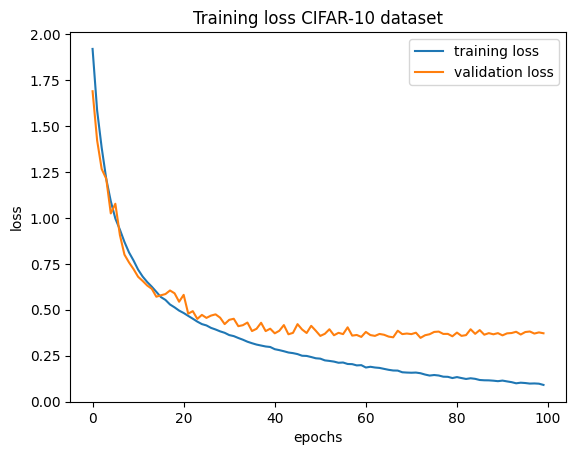

In [ ]:

models = [
    (adaIpsModel, 'adaips optimizer'),
    # (adamModel, 'adam optimizer'),
    # (adaIpsModel_, 'adaips per param optimizer'),

    # (ipsModel, 'ips optimizer')

]
exclude = []
focus = [adaIpsModel]
interval = 1
for model, optimizer in models:
    if model in exclude: continue
    plt.plot(
        [i for i, loss in enumerate(model.t_losses) if i % interval == 0],
        [loss for i, loss in enumerate(model.t_losses) if i % interval == 0],
        label="training loss",
        alpha=0.5 if model not in focus else 1
    )
    plt.plot(
        [i for i, loss in enumerate(model.v_losses) if i % interval == 0],
        [loss for i, loss in enumerate(model.v_losses) if i % interval == 0],
        label="validation loss",
        alpha=0.5 if model not in focus else 1
    )
plt.title("Training loss CIFAR-10 dataset")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
for model, opt in models:
    torch.save(model, f"{opt.split(' ')[0]}_cifar_vanilla.pth")

In [ ]:
test(adaIpsModel, testloader)

Accuracy: 0.9061
Precision: 0.9067
Recall: 0.9061
F1-score: 0.9059
